This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [17]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = "."

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}/./data'.format(path_prefix),  train=True,download=True, transform=transform)

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [19]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(VAE,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.flatten = nn.Flatten()
                self.enc1 = nn.Linear(784, output_size)
                self.mean = nn.Linear(output_size, output_size)

                # Since it doesn't tell us whether we could use activation function for std layer,
                # to make sure all std > 0, and simplify the calculation of KL divergency
                # I train logstd2(which is log(std^2)), and calculate std using logstd2
                # self.logstd2 = nn.Linear(output_size, output_size, bias=False)
                self.logstd2 = nn.Linear(output_size, output_size)

            def forward(self, x):
                # needs your implementation
                x = self.flatten(x)
                # print(f'Encoder input: {x.size()}')
                x = self.enc1(x)
                mean_out = self.mean(x)
                # logstd2 represents log(std^2)
                logstd2_out = self.logstd2(x)
                return mean_out, logstd2_out

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.dec1 = nn.Linear(input_size,784)
                self.sig = nn.Tanh()

            def forward(self, z):
                # needs your implementation
                out = self.dec1(z)
                flat = self.sig(out)
                return flat.reshape((flat.size()[0],1,28,28))

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.bseweight = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.kldweight = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         # return (x with Gaussian noise)
    #     elif noise_type=='Dropout':
    #         return (x with Dropout noise)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        if self.training:
            # Since, make z belongs to N(mu, var^2)
            # is equal to z = mu + eps * var and eps belongs to N(0,1)
            # to simplify the calculation, my logvar is not log(std), it is log(std^2)
            eps = torch.normal(mean=0, std=1, size=logvar.shape)
            if torch.cuda.is_available():
                device = 'cuda:0'
            else:
                device = 'cpu'
            eps = eps.to(device)
            reparameter = mu + torch.exp(torch.div(logvar, 2)) * eps
            return reparameter
        else:
            return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        bseweight = self.bseweight.data.fill_(0.8)
        # kld need a weight about 0 to warm up, otherwise, it will overfit
        kldweight = self.kldweight.data.fill_(0.0001)
        mu, logvar = self.encoder(x)
        latent_z = self.reparameterise(mu=mu, logvar=logvar)
        x = self.decoder(latent_z)
        # for the VAE forward function should also return mu and logvar
        return x, mu, logvar, bseweight, kldweight

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [20]:
from VAE_starter import VAE_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = VAE(dim_latent_representation=30)
trainer = VAE_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:07<00:00, 257.26it/s]


====> Epoch: 1 Average loss: 0.4930


100%|██████████| 313/313 [00:02<00:00, 132.10it/s]


====> Val set loss (reconstruction error) : 0.4245


100%|██████████| 1875/1875 [00:07<00:00, 257.32it/s]


====> Epoch: 2 Average loss: 0.4427


100%|██████████| 313/313 [00:02<00:00, 137.45it/s]


====> Val set loss (reconstruction error) : 0.4174


100%|██████████| 1875/1875 [00:07<00:00, 260.10it/s]


====> Epoch: 3 Average loss: 0.4374


100%|██████████| 313/313 [00:02<00:00, 140.68it/s]


====> Val set loss (reconstruction error) : 0.4116


100%|██████████| 1875/1875 [00:07<00:00, 254.59it/s]


====> Epoch: 4 Average loss: 0.4361


100%|██████████| 313/313 [00:02<00:00, 143.79it/s]


====> Val set loss (reconstruction error) : 0.4133


100%|██████████| 1875/1875 [00:07<00:00, 258.23it/s]


====> Epoch: 5 Average loss: 0.4353


100%|██████████| 313/313 [00:02<00:00, 134.77it/s]


====> Val set loss (reconstruction error) : 0.4106


100%|██████████| 1875/1875 [00:07<00:00, 258.76it/s]


====> Epoch: 6 Average loss: 0.4348


100%|██████████| 313/313 [00:02<00:00, 140.15it/s]


====> Val set loss (reconstruction error) : 0.4123


100%|██████████| 1875/1875 [00:06<00:00, 271.53it/s]


====> Epoch: 7 Average loss: 0.4344


100%|██████████| 313/313 [00:02<00:00, 138.82it/s]


====> Val set loss (reconstruction error) : 0.4111


100%|██████████| 1875/1875 [00:07<00:00, 264.00it/s]


====> Epoch: 8 Average loss: 0.4342


100%|██████████| 313/313 [00:02<00:00, 139.40it/s]


====> Val set loss (reconstruction error) : 0.4069


100%|██████████| 1875/1875 [00:07<00:00, 251.85it/s]


====> Epoch: 9 Average loss: 0.4340


100%|██████████| 313/313 [00:02<00:00, 128.46it/s]


====> Val set loss (reconstruction error) : 0.4123


100%|██████████| 1875/1875 [00:07<00:00, 247.98it/s]


====> Epoch: 10 Average loss: 0.4338


100%|██████████| 313/313 [00:02<00:00, 129.57it/s]

====> Val set loss (reconstruction error) : 0.4120


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

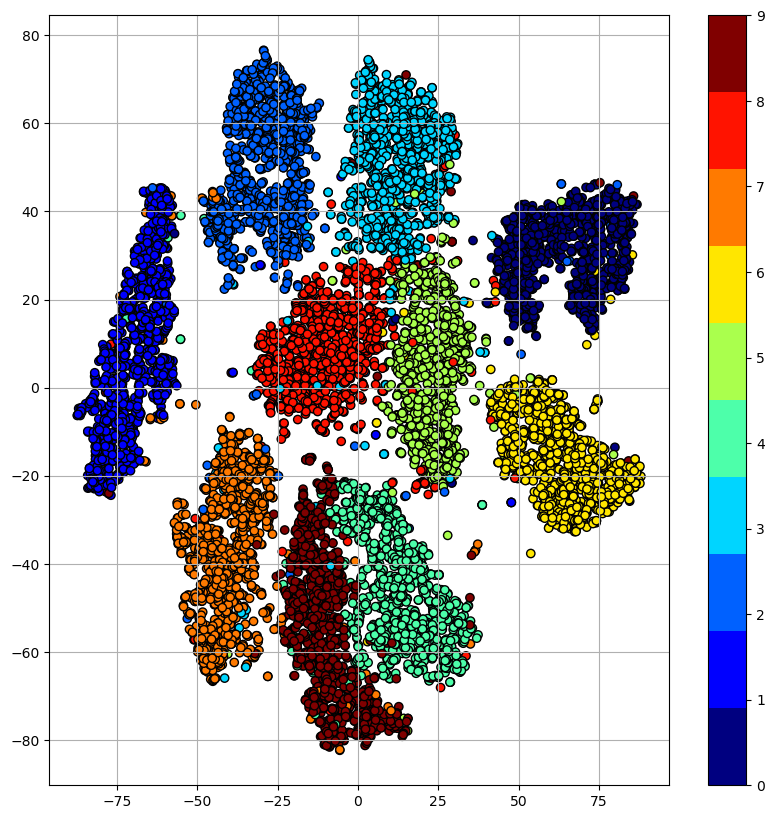

In [21]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_, logstd2 = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from VAE_starter import scatter_plot_TSNE
scatter_plot_TSNE(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


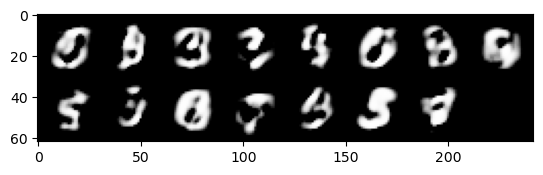

In [22]:
with torch.no_grad():
    samples = torch.randn(15, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from VAE_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


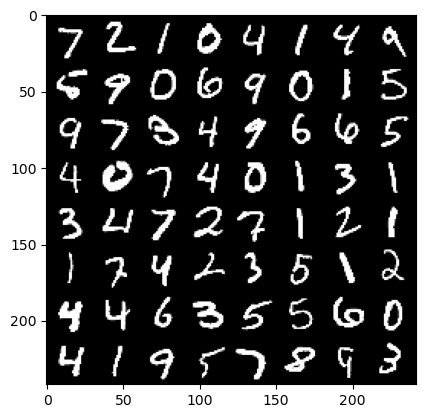

In [23]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from VAE_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


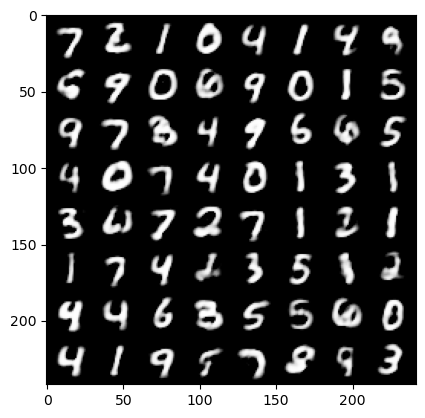

In [24]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed, mu, logvar, bseweight, kldweight = trainer.model(images)
    reconstructed = reconstructed.cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)